In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.odr import * 

In [2]:
data = pd.read_csv('isocro.csv', header = 0)
data.tail()

,Full,log(Age),M,log(Teff),Mbol,Mv,(U-B)o,(B-V)o,(V-R)o,(V-I)o,(V-J)o
6556,6557,6.6,51.8303,4.306,-9.88,-7.96,-0.88,-0.21,-0.09,-0.21,-0.51
6557,6558,6.6,51.8353,4.238,-9.89,-8.36,-0.81,-0.18,-0.06,-0.16,-0.42
6558,6559,6.6,51.8403,4.173,-9.90,-8.73,-0.69,-0.16,-0.05,-0.12,-0.33
6559,6560,6.6,51.8453,4.069,-9.92,-9.32,-0.44,-0.12,-0.02,-0.05,-0.19
6560,6561,6.6,51.8503,3.980,-9.93,-9.75,-0.21,-0.05,0.01,0.02,-0.02


In [3]:
idades = data['log(Age)']
age = np.array([])
for element in idades:
    if element in age:
        continue
    elif element not in age:
        age = np.append(age,element)
age

array([10.3 , 10.28, 10.26, 10.24, 10.22, 10.2 , 10.18, 10.16, 10.14,
       10.12, 10.1 , 10.08, 10.06, 10.04, 10.02, 10.  ,  9.9 ,  9.8 ,
        9.7 ,  9.6 ,  9.5 ,  9.4 ,  9.3 ,  9.2 ,  9.1 ,  9.  ,  8.9 ,
        8.8 ,  8.7 ,  8.6 ,  8.5 ,  8.4 ,  8.3 ,  8.2 ,  8.1 ,  8.  ,
        7.9 ,  7.8 ,  7.7 ,  7.6 ,  7.5 ,  7.4 ,  7.3 ,  7.2 ,  7.1 ,
        7.  ,  6.9 ,  6.8 ,  6.7 ,  6.6 ])

In [5]:
Mvarray = []
Bvarray = []
for element in age:
    a = data[data['log(Age)']==element]
    b = a['Mv'].tolist()
    c = a['(B-V)o'].tolist()
    Mvarray.append(b)
    Bvarray.append(c)

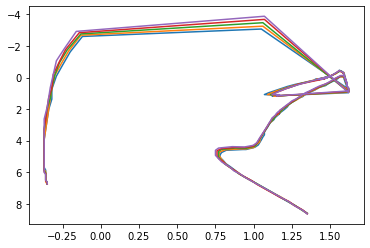

In [6]:
plt.gca().invert_yaxis()
for i in range(1,6):
    plt.plot(Bvarray[i],Mvarray[i])

In [6]:
from scipy import stats

#REGRESSAO SEM SIGMA CLIPPING
f = open("Regression_Iso(No_SigmaClipping).txt", "w")
f.write("Age,Slope,Intercept,Slope_Error,Intercept_Error,R_Value,BvTof,MvTof \n")
for i in range(0,len(age)):
    lx = Bvarray[i]
    ly = Mvarray[i]
    a = 0
    index = 0
    for element in lx:
        if a>= 1:
            if lx[a-1] - element <0:
                index = a-1
                break
        a+=1

    valor = lx[index]
    b = 0
    for element in lx:
        if element == valor:
            index = b
            break
        b+=1
    x1 = lx[:index]
    y1 = ly[:index]
    
    Bvturnoff = lx[index]
    Mvturnoff = ly[index]
    
    result = stats.linregress(x1,y1)
    f.write(str(age[i]) + ', ' + str(result.slope) + ', ' + str(result.intercept) + ', ' + str(result.stderr) + ', ' + str(result.intercept_stderr) +  ', ' + str(result.rvalue)  +  ', ' + str(Bvturnoff) + ', ' + str(Mvturnoff) + '\n')
f.close()
    


In [7]:
def linear_func(p, x):
    m, c = p
    return m*x + c

In [8]:
from scipy import stats
f = open("Regression_Iso.txt", "w")
f.write("Age,Slope,Intercept,Slope_Error,Intercept_Error,R_Value,(B-V)TurnOff,MvTurnOff, Ajustadas/Total\n")
for i in range(0,len(age)):
    lx = Bvarray[i]
    ly = Mvarray[i]
    a = 0
    index = 0
    for element in lx:
        if a>= 1:
            if lx[a-1] - element <0:
                index = a-1
                break
        a+=1

    valor = lx[index]
    b = 0
    for element in lx:
        if element == valor:
            index = b
            break
        b+=1
    x1 = lx[:index] #indice [:index] eh para pegar estrelas ate o turn off point. turn off point definido na iteracao acima.
    y1 = ly[:index]
    Bvturnoff = lx[index]
    Mvturnoff = ly[index]
    
    # Efetuar o sigma clipping #
    result = stats.linregress(x1,y1)  
    
    x1 = np.asarray(x1)
    y1 = np.asarray(y1)
    
    t_fit = np.linspace(x1.min(),x1.max(),len(x1))
    sigmay = np.sqrt((t_fit*result.stderr)**2 + (result.intercept_stderr)**2)

    xadj = []
    yadj = []

    count = 0
    ytentativa = result.slope*x1 + result.intercept
    for element in y1:
        if ytentativa[count] + sigmay[count] >= element and ytentativa[count] - sigmay[count] <= element:
            xadj.append(x1[count])
            yadj.append(y1[count])
        count+=1
    xadj = np.asarray(xadj)
    yadj = np.asarray(yadj)

    razao = str(len(xadj)/len(x1)) + '= ' + str(len(xadj)) + '/' + str(len(x1))
    
    #Nova regressao para as estrelas que sao pertencentes ao intervalo sigma#
    final_regression = stats.linregress(xadj,yadj)
    
    f.write(str(age[i]) + ', ' + str(final_regression.slope) + ', ' +  str(final_regression.intercept) + ', ' + str(final_regression.stderr) + ', ' + 
            str(final_regression.intercept_stderr) +  ', ' + str(final_regression.rvalue) + ', '+ str(Bvturnoff) + ', ' + str(Mvturnoff) + ', ' + razao + '\n')
f.close()
    


In [9]:
from scipy import stats
f = open("Regression_Iso3Sigma.txt", "w")
f.write("Age,Slope,Intercept,Slope_Error,Intercept_Error,R_Value,(B-V)TurnOff,MvTurnOff, Ajustadas/Total\n")
for i in range(0,len(age)):
    lx = Bvarray[i]
    ly = Mvarray[i]
    a = 0
    index = 0
    for element in lx:
        if a>= 1:
            if lx[a-1] - element <0:
                index = a-1
                break
        a+=1

    valor = lx[index]
    b = 0
    for element in lx:
        if element == valor:
            index = b
            break
        b+=1
    x1 = lx[:index] #indice [:index] eh para pegar estrelas ate o turn off point. turn off point definido na iteracao acima.
    y1 = ly[:index]
    Bvturnoff = lx[index]
    Mvturnoff = ly[index]
    
    # Efetuar o sigma clipping #
    result = stats.linregress(x1,y1)  
    
    x1 = np.asarray(x1)
    y1 = np.asarray(y1)
    
    t_fit = np.linspace(x1.min(),x1.max(),len(x1))
    sigmay = np.sqrt((t_fit*result.stderr)**2 + (result.intercept_stderr)**2)

    xadj = []
    yadj = []

    count = 0
    ytentativa = result.slope*x1 + result.intercept
    for element in y1:
        if ytentativa[count] + 3*sigmay[count] >= element and ytentativa[count] - 3*sigmay[count] <= element:
            xadj.append(x1[count])
            yadj.append(y1[count])
        count+=1
    xadj = np.asarray(xadj)
    yadj = np.asarray(yadj)

    razao = str(len(xadj)/len(x1)) + '= ' + str(len(xadj)) + '/' + str(len(x1))
    
    #Nova regressao para as estrelas que sao pertencentes ao intervalo sigma#
    final_regression = stats.linregress(xadj,yadj)
    
    f.write(str(age[i]) + ', ' + str(final_regression.slope) + ', ' +  str(final_regression.intercept) + ', ' + str(final_regression.stderr) + ', ' + 
            str(final_regression.intercept_stderr) +  ', ' + str(final_regression.rvalue) + ', '+ str(Bvturnoff) + ', ' + str(Mvturnoff) + ', ' + razao + '\n')
f.close()
    
